# Demo NeuroEvolution donde se aplica algoritmo de Programación Genética para generar una RNA (MLP o ConvNet) con librería TF-Keras para procesar imágenes e identificar la clase que corresponde

Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

Nota: se usa GPU para entrenar más rápido, pero también funciona con CPU.

In [ ]:
#@title Instalar librerías

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,03

In [ ]:
#@title Cargar librerías
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from functools import partial

import random
from random import sample
import copy

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image

import pickle
import codecs

import matplotlib
import networkx
from IPython.display import display
from PIL import Image

import os
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import math

import os
import csv

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("\nLibrerías importadas")


Librerías importadas


##Imágenes:

In [ ]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  240
- Ejemplo  0   (32, 32, 3) : 


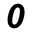



> Para Prueba: 
- Clases cargadas:  10
- Imágenes cargadas:  60
- Ejemplo  0   (32, 32, 3) : 


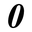

In [ ]:
#@title Cargar imágenes

#@markdown ### Parámetros para imágenes:
imagen_ancho =  32#@param {type:"integer"}
imagen_largo =  32#@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:


            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)

            # ajusta el tamaño
            if IMAGE_SHAPE[2]==1:
              tipoImage = 'L'
            else:
              tipoImage = 'RGB'
            imag = imag.convert(tipoImage)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

            # transforma a un vector de nros
            arImag = np.array(imag)

            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag )

  return classes_ori, images_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

In [ ]:
#@title Ajustar imágenes para reducir el fondo (opcional)

accion_realizar = "-" #@param ["-", "Blur Fondo", "Eliminar Fondo y pasar a Negro", "Eliminar Fondo y pasar a Blanco"]

def cambiarColorNegro(img, nuevoColor=[255, 255, 255]):
    black_pixels = np.where(
        (img[:, :, 0] == 0) &
        (img[:, :, 1] == 0) &
        (img[:, :, 2] == 0)
    )
    img[black_pixels] = nuevoColor
    return img

def blurFondoImagen(im):
  # Convert to the HSV color space
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(hsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # We need a to copy the mask 3 times to fit the frames
  maskthresh = np.repeat(maskthresh[:, :, np.newaxis], 3, axis=2)
  #  Create a blurred frame using Gaussian blur
  blurred_frame = cv2.GaussianBlur(im, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  return np.where(maskthresh == (255, 255, 255), im, blurred_frame)

def reducirFondoImagen(im):
  # aplica filtro Hue
  imhsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(imhsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # aplica la máscara sobre la imagen
  imgfin = cv2.bitwise_and(im, im, mask = maskthresh)
  return imgfin

def procesarImgRedFondo(imgList):
  nList = []
  for im in imgList:
    if accion_realizar == "Blur Fondo":
      # hacer blur del fondo
      imn = blurFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Negro":
      # eliminar fondo y dejar negro
      imn = reducirFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Blanco":
        # cambia fondo negro a casi negro
        # (para que no cambié después)
        imn = cambiarColorNegro(im, [0, 0, 1])
        # eliminar fondo
        imn = reducirFondoImagen(imn)
        # cambiar fondo a blanco
        imn = cambiarColorNegro(imn, [255, 255, 255])
    else:
      print("Acción no definida!")
      break
    nList.append( imn )
  return nList


# degermina si hace algo o no
if accion_realizar != "-":
  # aplica filtros para intentar reducir el fondo de la imagen
  # cambiando las imágenes disponibles
  images_train = procesarImgRedFondo(images_train)
  images_test = procesarImgRedFondo(images_test)

  if len(classes_train)>0:
    print("- Ejemplo Entrenamiento con fondo reducido ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  if len(classes_test)>0:
    print("- Ejemplo Prueba con fondo reducido ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (240, 32, 32, 3)
 - y_trainEnc (cant):  240
 - y_train (cant):  240


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (60, 32, 32, 3)
 - y_testEnc (cant):  60
 - y_test (cant):  60


> Para Ambos: 
 - dictMapeo:  {'9': 0, '2': 1, '7': 2, '1': 3, '3': 4, '8': 5, '5': 6, '0': 7, '6': 8, '4': 9}
 - clases_map:  ['9', '2', '7', '1', '3', '8', '5', '0', '6', '4']

 - Imagen reconstruida de  0 ( 7  /  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] )


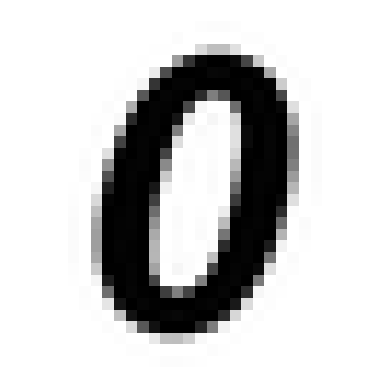

In [ ]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8)) ## *255
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8)) ## *255
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
  auxiAr = np.array(imagList) ##.astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

# Modelo RNA:

In [ ]:
#@title Funciones auxiliares para manejar la configuración de RNA con Programación Genética


#@markdown Topología Modelo RNA:
modelo_tipo_red = "ConvNet" #@param ["MLP", "ConvNet"]
rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown Entrenamiento Modelo RNA:
modelo_cant_epocas_entrenamiento_base = 10 #@param {type:"integer"}

#@markdown Función de Aptitud:
fitness_calc_usando = "Validacion" #@param ["Entrenamiento", "Validacion", "Entrenamiento + Validacion"]
fitness_penalizar_x_topologia = True #@param {type:"boolean"}

# determina datos a usar
if True: #esProblemaClasificacion:
  tipo_output_softMax = (rna_tipo_capa_salida == 'softmax-MultiClase')
else:
  tipo_output_softMax = False

# determina tipo de red
generaConvNet = (modelo_tipo_red == "ConvNet")


import json

# Listas de Opciones de configuración
PG_tipoFuncList = ["relu", "exponential", "linear", "sigmoid", "tanh"]
PG_optTipoList = ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]


# Funciones auxiliares para configuración del modelo en PG

def defaultConfigDictModel(id=None):
    # inicialización de configuración de la red
    # con parámetros por defecto
    configModel = {}
    if id is not None:
      configModel["ID"] = str(id)
    # parámetros entrenamiento
    configModel["epochs"] = max(modelo_cant_epocas_entrenamiento_base, 10)
    # parámetros optimización
    configModel["optTipo"] = "Adam"
    configModel["optLearningRate"] = 0.001
    # parámetros capas ocultas lineales (dense, DO, BN)
    configModel["hiddenLayers"] = "0"
    configModel["funcTipo"] = "relu"
    configModel["porcDropOut"] = 0.1
    # parámetros capas ocultas convNet
    configModel["convLayers"] = (1 if generaConvNet else 0)
    configModel["convKernelShape"] = 2
    configModel["convPoolType"] = "Max"
    configModel["convPoolShape"] = 2
    configModel["useGlobalAveragePooling"] = 0
    return configModel

def defaultConfigstrModel(id=None):
    # idem anterio pero devuelve como string
    return strConfig( defaultConfigDictModel(id) )

def strConfig(configDict):
    # convierte config de dict a string
    return json.dumps(configDict)

def dictConfig(configStr):
    # convierte config de string a dict
    return json.loads(configStr)

def showConfigDictModel(configModel):
    # muestra en forma amigable al configuración
    print("\n> Configuración del modelo RNA id: " + configModel["ID"])
    if configModel["convLayers"] > 0:
        print("\t con " + str(configModel["convLayers"]) + " capas convolucionales:")
        print("\t\t kernel shape: " + str(configModel["convKernelShape"]))
        print("\t\t pooling tipo: " + str(configModel["convPoolType"]) + " y shape: " + str(configModel["convPoolShape"]))
        if configModel["useGlobalAveragePooling"] == 1:
          print("\t\t usando GlobalAveragePooling2D")
        else:
          print("\t\t usando Flatten")
    if configModel["hiddenLayers"] == "0":
        print("\t sin capas ocultas lineales ")
    else:
        listaOcultas = configModel["hiddenLayers"].split(",")
        print("\t con " + str(len(listaOcultas)-1) + " capas ocultas:")
        print("\t\t función neuronas: " +configModel["funcTipo"])
        if "D" in listaOcultas:
          print("\t\t porcentaje DropOut: " + str(configModel["porcDropOut"]))
    print("\t algoritmo de optimización: " + configModel["optTipo"] + ", learning rate: " + str(configModel["optLearningRate"]) )
    print("\t y entrenamiento con " + str(configModel["epochs"]) + " épocas.")
    print("")

# Primitivas para manejar configuración del modelo en PG

def configFuncLayers(configStr, tipoFuncionInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura tipo de función para capas Conv y Dense
    if (tipoFuncionInt>=0):
      auxId = tipoFuncionInt % len(PG_tipoFuncList)
      configModel["funcTipo"] = PG_tipoFuncList[auxId]
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def addDenseLayer(configStr, cantNeuronas):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # agrega una capa Dense (MLP)
    if cantNeuronas>0:
      configModel["hiddenLayers"] = configModel["hiddenLayers"] + "," + str(cantNeuronas)
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def addBatchNormalizationLayer(configStr):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # agrega una capa BatchNormalization
    configModel["hiddenLayers"] = configModel["hiddenLayers"] + ",BN"
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def addDropOutLayer(configStr):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # agrega una capa DropOut
    configModel["hiddenLayers"] = configModel["hiddenLayers"] + ",D"
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configDropOut(configStr, porcInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura porcentaje de capas DropOuts
    if porcInt<0:
      porcInt = 1
    elif porcInt>90:
      porcInt = 90
    configModel["porcDropOut"] = float(porcInt)/100.0
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def addConvLayer(configStr):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # agrega una capa convolucional completa (nota: siempre van adelante de las 'hidden')
    configModel["convLayers"] = configModel["convLayers"] + 1
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configConvLayers(configStr, cantLayers):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura una cantidad capas Convs completas
    # (nota1: sobreescribe configuración anterior de cantidad de capas convs)
    # (nota2: siempre van adelante de las 'hidden')
    if cantLayers<0:
      cantLayers = 0
    elif cantLayers>10:
      cantLayers = (cantLayers % 10)+1
    configModel["convLayers"] = cantLayers
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configConvKernelShape(configStr, shape):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura kernel shape de etapas Convs (si están disponibles)
    if shape<1:
      shape = 1
    elif shape>10:
      shape = (shape % 10)+1
    configModel["convKernelShape"] = shape
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configPoolShape(configStr, shape):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # determina shape de etapas Poolings (si están disponibles)
    if shape<1:
      shape = 1
    elif shape>10:
      shape = (shape % 10)+1
    configModel["convPoolShape"] = shape
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configPoolType(configStr, tipoInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # determina tipo de etapas Poolings (si están disponibles)
    if (tipoInt % 2)==0:
      auxTipo = "Max"
    else:
      auxTipo = "Avg"
    configModel["convPoolType"] = auxTipo
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configGlobalAveragePooling(configStr, yesno):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # determina tipo de etapas Poolings (si están disponibles)
    configModel["useGlobalAveragePooling"] = (yesno % 2)
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configAlgOpt(configStr,  optTipoInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura algoritmo de optimización
    if (optTipoInt>=0):
      auxId = optTipoInt % len(PG_optTipoList)
      configModel["optTipo"] = PG_optTipoList[auxId]
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configLearnRate(configStr, learningRateInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura learning reate
    if learningRateInt>0:
      configModel["optLearningRate"] = float(learningRateInt)/100.0
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)


def addEpochs(configStr, epochs):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura learning reate
    if epochs>0:
      configModel["epochs"] = configModel["epochs"] + epochs
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

print("Funciones para configuración de RNA definidas.")

Funciones para configuración de RNA definidas.


In [ ]:
#@title Definir clase auxiliar para el ambiente para RNA con Programación Genética

#@markdown Parámetros:
rna_env_cache_en_memoria = False #@param {type:"boolean"}
rna_env_debug = False #@param {type:"boolean"}


# configuración del enviroment
configRNAEnv = {}
if fitness_calc_usando == "Entrenamiento":
  configRNAEnv["calcFitness"] = "E"
elif fitness_calc_usando == "Validacion":
  configRNAEnv["calcFitness"] = "V"
else:
  configRNAEnv["calcFitness"] = "E+V"
configRNAEnv["penalFitness"] = fitness_penalizar_x_topologia
configRNAEnv["cacheInMemory"] = rna_env_cache_en_memoria


# constantes auxiliares
cons_WorstValue = -99.9
cont_BestValue = 100.0

# clase
class RNA_PG_Environment(object):

    def __init__(self, x_data, y_data, IMAGE_SHAPE,
                 config=None, DEBUG=False):
        # inicializa el ambiente para usar Programación Genética
        print("> Preparando el ambiente...")
        self.DEBUG = DEBUG

        # calida parámetros de data
        assert x_data is not None, "-- x_data no definido!"
        assert len(x_data)>0, "-- x_data vacío!"
        assert y_data is not None, "--  y_data no definido!"
        assert len(y_data)>0, "-- y_data vacío!"

        if config is None:
            # define parámetros por defecto
            self.calcFitness = "V"
            self.penalFitness = True
            self.cacheInMemory = True
        else:
            self.calcFitness = config["calcFitness"]
            self.penalFitness = config["penalFitness"]
            self.cacheInMemory = configRNAEnv["cacheInMemory"]

        if True: # siempre esProblemaClasificacion
            # para problema de clasificación
            print(" Configurado para problema de Clasificación.")
            self.esClasificacion = True
            # determina neuronas de entrada y salida
            self.IMAGE_SHAPE = IMAGE_SHAPE
            self.x_cantAtt = np.prod(np.array(self.IMAGE_SHAPE))
            # determina si es salida softmax o no
            if len(y_data.shape)==1:
              self.y_cantAtt = 1
            else:
              self.y_cantAtt = y_data.shape[1]
        else:
            # para problema de Estimación
            print(" Configurado para problema de Estimación.")
            self.esClasificacion = False
            # determina neuronas de entrada y salida
            self.IMAGE_SHAPE = IMAGE_SHAPE
            self.x_cantAtt = np.prod(np.array(self.IMAGE_SHAPE))
            self.y_cantAtt = 1
        self.dataLength = len(x_data)

        # valida resultados previos
        assert self.dataLength > 0, "-- dataLength debe ser mayor a 0"
        assert self.x_cantAtt > 0, "-- x_cantAtt debe ser mayor a 0"
        assert self.y_cantAtt > 0, "-- y_cantAtt debe ser mayor a 0"

        print(" Definiendo parámetros para cálculo de aptitud: ")
        print("        calcFitness = ", self.calcFitness)
        print("        penalFitness = ", self.penalFitness)

        if self.calcFitness == "E":
            # se toman todos los datos para entrenamiento
            self.x_train, self.y_train, x_data, y_data
            self.x_val, self.y_val = [], []
            self.x_eval, self.y_eval = x_data, y_data
        else:
            # separa al azar usando muestreo al azar del 10%
            # para tomar algunos como datos de validación
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(x_data, y_data,
                                                                                    test_size=0.1)
            if self.calcFitness == "V":
              # para calculo de fitness (eval) se usa solamente los de validación
              self.x_eval, self.y_eval = self.x_val, self.y_val
            else: #  "E+V":
              # para calculo de fitness (eval) se usan todos (pero los de validación no se usan para entrenar)
              self.x_eval, self.y_eval = x_data, y_data

        print("  Definiendo datos: de los ", len(x_data), "ejemplos de entrenamiento: ")
        print("                      se usan ", len(self.x_train), "ejemplos para entrenar ")
        print("                      se usan ", len(self.x_val), "ejemplos para validar")
        print("                      y ", len(self.x_eval), "ejemplos para calcular fitness.")

        # prepara datos entrenamiento como array
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train).reshape(len(self.y_train), self.y_cantAtt)
        # prepara datos validación como array
        self.x_val = np.array(self.x_val)
        self.y_val = np.array(self.y_val).reshape(len(self.y_val), self.y_cantAtt)
        # prepara datos evaluación
        self.x_eval = np.array(self.x_eval)
        self.y_eval = np.array(self.y_eval).reshape(len(self.y_eval), self.y_cantAtt)

        # valida resultados
        assert self.x_train is not None, "--  x_train no definido!"
        assert len(self.x_train)>0, "-- x_train vacío!"
        assert self.y_train is not None, "-- y_train no definido!"
        assert len(self.y_train)>0, "-- y_train vacío!"
        assert self.x_eval is not None, "--  x_eval no definido!"
        assert len(self.x_eval)>0, "-- x_eval vacío!"
        assert self.y_eval is not None, "-- y_eval no definido!"
        assert len(self.y_eval)>0, "-- y_eval vacío!"

        print(" Topología base de la red: ")
        print("\t -Capa Entrada: ", self.IMAGE_SHAPE, "[", self.x_cantAtt, "] / x_train: ",  self.x_train.shape)
        print("\t -Capa Salida: ", self.y_cantAtt,  " / y_train " ,  self.y_train.shape)
        print("\n")

        self.models_cache_reset()
        return


    # * Manejo del modelo RNA

    def _create_model(self, configModel):
      assert configModel is not None, "-- create_model: configuración de modelo no definida!"
      # crea la red en base a la configuración dada
      penalFitnessVal = 0
      model = keras.Sequential()
      model.name = "Model_" + configModel.get("ID", "?")
      if self.DEBUG:
        print("\n- create_model: ")
        for k in configModel:
            print("\t ", k, " = ", configModel[k])
        print("")
      # agrega capa de entrada
      model.add( keras.layers.Input(shape=self.IMAGE_SHAPE, name='input') )
      # agrega capa para ajuste de imágenes
      model.add( tf.keras.layers.Rescaling(1./255, name='slng_1_div_255') )
      # define parámetros generales para capas
      funcTipo = configModel["funcTipo"]
      porc_DropOut = configModel["porcDropOut"]
      if "," in configModel["hiddenLayers"]:
        hiddLayers = configModel["hiddenLayers"].split(',')
      else:
        hiddLayers = [ configModel["hiddenLayers"] ]
      idHiddLay = 0
      # procesa capas Convolucionales (si corresponde)
      if configModel["convLayers"]>0:
          # parámetros para capas convolucionales
          cnn_kernel_shape = (configModel["convKernelShape"], configModel["convKernelShape"])
          cnn_pooling_shape = (configModel["convPoolShape"], configModel["convPoolShape"])
          if configModel["convPoolType"] == "Max":
              cnn_pooling_layer = keras.layers.MaxPooling2D
          else:
              cnn_pooling_layer = keras.layers.AveragePooling2D
          # agrega capas convolucionales
          for i in range(configModel["convLayers"], 0, -1):
              cnn_filters = 2**(i+2)
              idHiddLay += 1
              auxlayerName = 'conv_c_'+str(idHiddLay)
              model.add( keras.layers.Conv2D(cnn_filters, cnn_kernel_shape, activation=funcTipo, padding='same', name=auxlayerName) )
              auxlayerName = 'conv_p_'+str(idHiddLay)
              model.add( cnn_pooling_layer(cnn_pooling_shape, padding='same', name=auxlayerName) )
              penalFitnessVal -= 0.05
          #  agrega capa GlobalAveragePooling2D o Flatten
          if configModel["useGlobalAveragePooling"]==1:
            model.add( keras.layers.GlobalAveragePooling2D(name='flat_GAP') )
          else:
            model.add( keras.layers.Flatten(name='flat') )
      else:
          #  agrega capa Flatten
          model.add( keras.layers.Flatten(name='flat') )
      # procesa capas ocultas MLP (si corresponde)
      for val in hiddLayers:
          idHiddLay += 1
          val = val.strip()
          if val == "D":
              # capa Dropout
              auxlayerName = "do_"+str(idHiddLay)
              model.add( keras.layers.Dropout(porc_DropOut, name=auxlayerName) )
              penalFitnessVal -= 0.08
          elif val == "BN":
              # capa BatchNormalization
              auxlayerName = "bn_"+str(idHiddLay)
              model.add( keras.layers.BatchNormalization(name=auxlayerName) )
              penalFitnessVal -= 0.08
          elif val.isnumeric():
              # capa dense
              if int(val)>0:
                auxlayerName = "h_"+str(idHiddLay)
                model.add( keras.layers.Dense(int(val), activation=funcTipo, name=auxlayerName) )
                penalFitnessVal -= float(val)/1000.0
              else:
                idHiddLay -= 1
          else:
            if self.DEBUG:
              print("-- create_model: capa ", val, "descartada!")
            idHiddLay -= 1
            penalFitnessVal -= 1
      # agrega capa de salida
      esSoftMax = ( self.esClasificacion and self.y_cantAtt>1 )
      if esSoftMax:
        model.add( keras.layers.Dense(units=self.y_cantAtt, activation="softmax", name='output') )
      else:
        model.add( keras.layers.Dense(units=1, activation=None, name='output') )
      # define algoritmo de optimización
      if configModel["optTipo"] == "Gradiente Decreciente":
        opt = keras.optimizers.SGD(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Adam":
        opt = keras.optimizers.Adam(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Adadelta":
        opt = keras.optimizers.Adadelta(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Adagrad":
        opt = keras.optimizers.Adagrad(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Adamax":
        opt = keras.optimizers.Adamax(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Nadam":
        opt = keras.optimizers.Nadam(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "FTRL":
        opt = keras.optimizers.Ftrl(learning_rate=configModel["optLearningRate"])
      else:
        opt = keras.optimizers.Adam()
      # compila modelo
      # notar que métrica (accuracy o R2 score) devuelve valor entre 0 y 1 (peor->mejor)
      if esSoftMax:
          # utiliza un loss de multiple clases
          model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
      else:
          # utiliza un loss de valor numérico
          if self.esClasificacion :
            model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
          else:
            model.compile(optimizer=opt, loss='mse', metrics=['R2Score'])
      return model, penalFitnessVal


    def _train_model(self, model, cantEpocas):
      # valida datos
      assert model is not None, "-- train_model: modelo no definido!"
      # valida cantidad de épocas
      cantEpocas = (1 if cantEpocas<1 else cantEpocas)
      # realiza el entrenamiento
      history = model.fit(self.x_train, self.y_train,
                              epochs = cantEpocas,
                              verbose = (1 if self.DEBUG else 0))
      # ver que datos extraer para cálculo de heurística
      return model, history


    def _eval_model(self, model, showDetails=False):
      # valida datos
      assert model is not None, "-- eval_model: modelo no definido!"
      # evalua el modelo
      resEval = model.evaluate(self.x_eval, self.y_eval,
                                    verbose=(1 if self.DEBUG else 0))
      modelMetric = resEval[1]
      if math.isnan(modelMetric):
        if self.DEBUG:
          print("-- eval_model: métrica modelo no definida, se cambia.")
        modelMetric = 0.0001
      elif modelMetric < 0:
        if self.DEBUG:
          print("-- eval_model: métrica modelo menor a cero, se cambia.")
        modelMetric = 0.0001
      else:
        modelMetric = round(modelMetric* 100.0, 4)
      if self.DEBUG or showDetails:
          print("\n- eval_model: métricas ")
          print("\t- Loss: ", round(resEval[0],3))
          print("\t- Métrica: ", modelMetric)
      return modelMetric


    def show_model(self, model, showPlot=True):
      # muestra el modelo generado
      assert model is not None, "-- show_model: modelo no definido!"
      print("Modelo creado con ", len(model.layers), " capas:")
      model.summary()
      print("\n")
      if showPlot:
        display( plot_model(model, show_layer_names=True, show_shapes=True) )
        print("")

    # * Funciones para calcular Fitness

    def calculate_fitness(self, configModel):
        # calcula valor de aptitud del modelo
        try:
            # crea el modelo
            indModel, indPenalFitness = self._create_model(configModel)
            if self.DEBUG:
              self.show_model(indModel, showPlot=False)
            # entrena modelo
            indModel, hist = self._train_model(indModel, configModel["epochs"])
            # evalúa al modelo
            indHeuristica = self._eval_model(indModel)
            # penaliza si corresponde
            if self.penalFitness:
              indHeuristica = indHeuristica + indPenalFitness/10.0
            # devuelve heuristica
            return round(indHeuristica, 4), indModel
        except Exception as e:
          if self.DEBUG:
            print("Error calculate_fitness: ", e)
          return cons_WorstValue, None

    def return_MaxFitness(self):
      # devuelve valor máximo posible para la aptitud
      return cont_BestValue


    # * Funciones para manejo de cache

    def _save_model(self, model, modelId, path="."):
      # guarda el modelo
      assert model is not None, "-- save_model: modelo no definido!"
      # si no existe el directorio, lo crea
      if (path!="."):
        if not os.path.isdir(path):
          os.makedirs(path)
      fn_model = path+"/model-" + modelId + ".keras"
      model.save(fn_model)
      if self.DEBUG:
        print("\n- save_model: guardado en ", fn_model,"\n")
      return fn_model


    def _load_model(self, fn_model):
      # recupera el modelo
      model = keras.models.load_model(fn_model)
      if self.DEBUG:
        print("\n- _load_model: recuperado de ", fn_model,"\n")
      return model

    @staticmethod
    def getIndividualId(individual):
      return hash(str(individual))

    def models_cache_reset(self):
      # inicializa cache rna
      self.cacheIndRna = {}
      self.cachePath = tempfile.TemporaryDirectory(prefix="cacheModels_").name
      if self.DEBUG:
        print("\n- models_cache_reset: cache inicializada en ", self.cachePath)

    def models_cache_get(self, individual):
      # se fija si está en la cache rna y lo devuelve
      # sino devuelve que no lo encuentra
      id = RNA_PG_Environment.getIndividualId(individual)
      if id in self.cacheIndRna:
        data = self.cacheIndRna[id]
        if self.cacheInMemory:
          model = data[2]
          if self.DEBUG:
            print("\n- models_cache_get: id ", id, "encontrado en memoria")
        else:
          # recupera el modelo guardado en archivo
          model = self. _load_model(data[2])
          if self.DEBUG:
            print("\n- models_cache_get: id ", id, "encontrado en archivo")
        # devuelve lo recuperado
        return True, id, data[0], data[1], model
      else:
        if self.DEBUG:
          print("\n- models_cache_get: id ", id, "no encontrado")
        # devuelve que no lo encuentra
        return False, id, cons_WorstValue, None, None

    def models_cache_set(self, individual, fitness, configModel, model):
        # guarda individual en la cache (si ya existía lo sobreescribe)
        id = RNA_PG_Environment.getIndividualId(individual)
        if self.cacheInMemory:
          # guarda directo en la cache
          self.cacheIndRna[id] = (fitness, configModel, model)
          if self.DEBUG:
            print("\n- models_cache_set: id ", id, "guardado en memoria")
        else:
          # guarda el modelo como archivo para liberar memoria
          fn_model = self._save_model(model, modelId=str(id), path=self.cachePath)
          self.cacheIndRna[id] = (fitness, configModel, fn_model)
          if self.DEBUG:
            print("\n- models_cache_set: id ", id, "guardado en archivo: ", fn_model)
        return True

print("Clase RNA_PG_Environment definida")

# inicializa la clase enviroment
modeloEnv = RNA_PG_Environment(x_data=x_train,
                           y_data=(y_trainEnc if tipo_output_softMax else y_train),
                           IMAGE_SHAPE=IMAGE_SHAPE,
                           config=configRNAEnv,
                           DEBUG=rna_env_debug)

print("\nRNA_PG_Environment inicializado")

Clase RNA_PG_Environment definida
> Preparando el ambiente...
 Configurado para problema de Clasificación.
 Definiendo parámetros para cálculo de aptitud: 
        calcFitness =  V
        penalFitness =  True
  Definiendo datos: de los  240 ejemplos de entrenamiento: 
                      se usan  216 ejemplos para entrenar 
                      se usan  24 ejemplos para validar
                      y  24 ejemplos para calcular fitness.
 Topología base de la red: 
	 -Capa Entrada:  (32, 32, 3) [ 3072 ] / x_train:  (216, 32, 32, 3)
	 -Capa Salida:  10  / y_train  (216, 10)



RNA_PG_Environment inicializado


# Algoritmo de Programación Genética:

In [ ]:
#@title PARÁMETROS del ALGORITMO

#@markdown Parámetros del Algoritmo de Programación Genética (PG):

# Cantidad de Ciclos de la Corrida
CANT_CICLOS =  35#@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 20 #@param {type:"slider", min:1, max:100, step:1}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [ ]:
#@title DEFINE LAS PRIMITIVAS DEL CROMOSOMA

incluir_primitivas_logicas = False #@param{"type":"boolean"}


# Agrega otras primitivas para Cromosoma

def pdiv(left, right):
    try:
        return int( int(left) // int(right) )
    except:
        return 1

# Define a new if-then-else function
def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

def comp_iguales(val1, val2):
    return (val1 == val2)

def comp_mas_grande(val1, val2):
    return (val1 > val2)

def comp_mas_chico(val1, val2):
    return (val1 < val2)


print("Funciones para Primitivas definidas.")


# Configura las primitivas permitidas para usar
# algunas son configurables (opcionales) y otras no
pset = gp.PrimitiveSetTyped("MAIN", [str, int, int, int], str)
# para manejo de configuración del modelo
pset.addPrimitive(configFuncLayers, [str, int], str)
pset.addPrimitive(addDenseLayer, [str, int], str)
pset.addPrimitive(addBatchNormalizationLayer, [str], str)
pset.addPrimitive(addDropOutLayer, [str], str)
pset.addPrimitive(configDropOut, [str, int], str)
if generaConvNet:
  pset.addPrimitive(addConvLayer, [str], str)
  pset.addPrimitive(configConvLayers, [str, int], str)
  pset.addPrimitive(configConvKernelShape, [str, int], str)
  pset.addPrimitive(configPoolShape, [str, int], str)
  pset.addPrimitive(configPoolType, [str, int], str)
  pset.addPrimitive(configGlobalAveragePooling, [str, int], str)
pset.addPrimitive(configAlgOpt, [str, int], str)
pset.addPrimitive(configLearnRate, [str, int], str)
pset.addPrimitive(addEpochs, [str, int], str)
# aritméticas básicas
pset.addPrimitive(operator.add, [int, int], int)
pset.addPrimitive(operator.sub, [int, int], int)
pset.addPrimitive(operator.mul, [int, int], int)
pset.addPrimitive(pdiv, [int, int], int)
pset.addPrimitive(max, [int, int], int)
pset.addPrimitive(min, [int, int], int)
# constantes numéricas
pset.addEphemeralConstant("constA",  partial(random.randint, 0, 100), int)
pset.addEphemeralConstant("constB",  partial(random.randint, 0, 100), int)
pset.addEphemeralConstant("constC",  partial(random.randint, 0, 100), int)
if incluir_primitivas_logicas:
  # lógicas
  pset.addPrimitive(operator.and_, [bool, bool], bool)
  pset.addPrimitive(operator.or_, [bool, bool], bool)
  pset.addPrimitive(operator.not_, [bool], bool)
  pset.addPrimitive(comp_iguales, [int, int], bool)
  pset.addPrimitive(comp_mas_grande, [int, int], bool)
  pset.addPrimitive(comp_mas_chico, [int, int], bool)
  pset.addPrimitive(if_then_else, [bool, str, str], str)
  pset.addTerminal(False, bool)
  pset.addTerminal(True, bool)


# parámetros del algortimo
pset.renameArguments(ARG0='configModelo')
pset.renameArguments(ARG1='x_cantAtts')
pset.renameArguments(ARG2='y_cantAtts')
pset.renameArguments(ARG3='data_length')

print("\nPrimitivas definidas")

Funciones para Primitivas definidas.

Primitivas definidas


In [ ]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
#@markdown - indica que es para maximizar.
#@markdown - determina la aptitud a partir de la métrica de la RNA entrenada

# indica que es la función de aptitud es para maximizar la métrica del modelo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


# función auxiliar para aplicar la expresión
# nota: usa una cache de los modelos para agilizar el proceso
def aplicaExpresion(individual, debug=False):
  try:
    if debug:
        print("\n - Expresion:", individual)
    # se fija si está en la cache
    isCached, idInd, fitness, dicConfigMod, model = modeloEnv.models_cache_get(individual)
    if isCached:
        if debug:
          print("\t recuperado de cache--> fitness:", fitness)
    else:
        # si encuentra en cache lo devuelve
        # Transforma la expresión del árbol en una función que se puede ejecutar
        func = toolbox.compile(expr=individual)
        # genera config incial y aplica las funcs del individuo
        # para definir la configuración del modelo
        strConfigMod = defaultConfigstrModel(idInd)
        strConfigMod = func(strConfigMod, modeloEnv.x_cantAtt, modeloEnv.y_cantAtt, modeloEnv.dataLength)
        # calcula aptitud en base a la configuración definida
        dicConfigMod = dictConfig(strConfigMod)
        fitness, model = modeloEnv.calculate_fitness(configModel=dicConfigMod)
        if debug:
          print("\t\t --> fitness:", fitness)
        # guarda en cache
        modeloEnv.models_cache_set(individual, fitness, dicConfigMod, model)
    # devuelve resultados
    return fitness, dicConfigMod, model
  except Exception as e:
    if debug:
      print("Error en aplicaExpresion: ", e)
    return cons_WorstValue, None, None

# función auxiliar para calcular la aptitud
def calculaAptitud(individual):
  # muestra progreso
  print(".", end="")
  # aplica la expresión del individuo y devuelve la aptitud
  aptitud, _ , _=  aplicaExpresion(individual, debug=False)
  return aptitud,

def formatearIndividuo(individual):
  return str(individual)

toolbox.register("evaluate", calculaAptitud)

print("\nFunción de Aptitud y Cromosoma definidos")


Función de Aptitud y Cromosoma definidos


In [ ]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Torneo", "Ranking"]

#@markdown  #####tipo_cruzamiento = 'Simple 1 punto corte'

# Probabilidad del Mutación
probab_mutacion = 0.55 #@param {type:"slider", min:0, max:1, step:0.05}


# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Estocastica':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


In [ ]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, " {", round(auxBestIndApt, 3), "}")
        print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxBestInd, auxMax, auxProm, auxMin


def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit[0],
  return fitnesses


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos, o si llega a una heurística mayor a: ", round(MIN_HEURISTICA_FINALIZAR,3) )
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")


print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [ ]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = cont_BestValue - 0.01

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# inicializa cache rna en cada ejecución
modeloEnv.models_cache_reset()

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

print("-- Generando población inicial")

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = asignarAptitud(indivPobla)
ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )
print("")

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = asignarAptitud(invalid_ind)
    print("")

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("== Mejor Individuo de la Corrida:", mejorIndCorrida, " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")


-- Generando población inicial
....................

-- Ciclo  0 --
 ++ Mejor Individuo: addEpochs(configModelo, 66)  { 91.66 }
      Max:  91.66  / Promedio:  25.0  / Min:  -99.9
....................

-- Ciclo  1 --
 ++ Mejor Individuo: addEpochs(configModelo, data_length)  { 95.83 }
      Max:  95.83  / Promedio:  60.61  / Min:  -0.03
....................

-- Ciclo  2 --
 ++ Mejor Individuo: addEpochs(configModelo, data_length)  { 95.83 }
      Max:  95.83  / Promedio:  86.03  / Min:  -0.01
....................

-- Ciclo  3 --
 ++ Mejor Individuo: addEpochs(configModelo, data_length)  { 95.83 }
      Max:  95.83  / Promedio:  88.33  / Min:  45.82
....................

-- Ciclo  4 --
 ++ Mejor Individuo: addEpochs(configModelo, data_length)  { 95.83 }
      Max:  95.83  / Promedio:  82.5  / Min:  -99.9
....................

-- Ciclo  5 --
 ++ Mejor Individuo: addEpochs(configModelo, data_length)  { 95.83 }
      Max:  95.83  / Promedio:  86.87  / Min:  4.16
....................

-- Ci

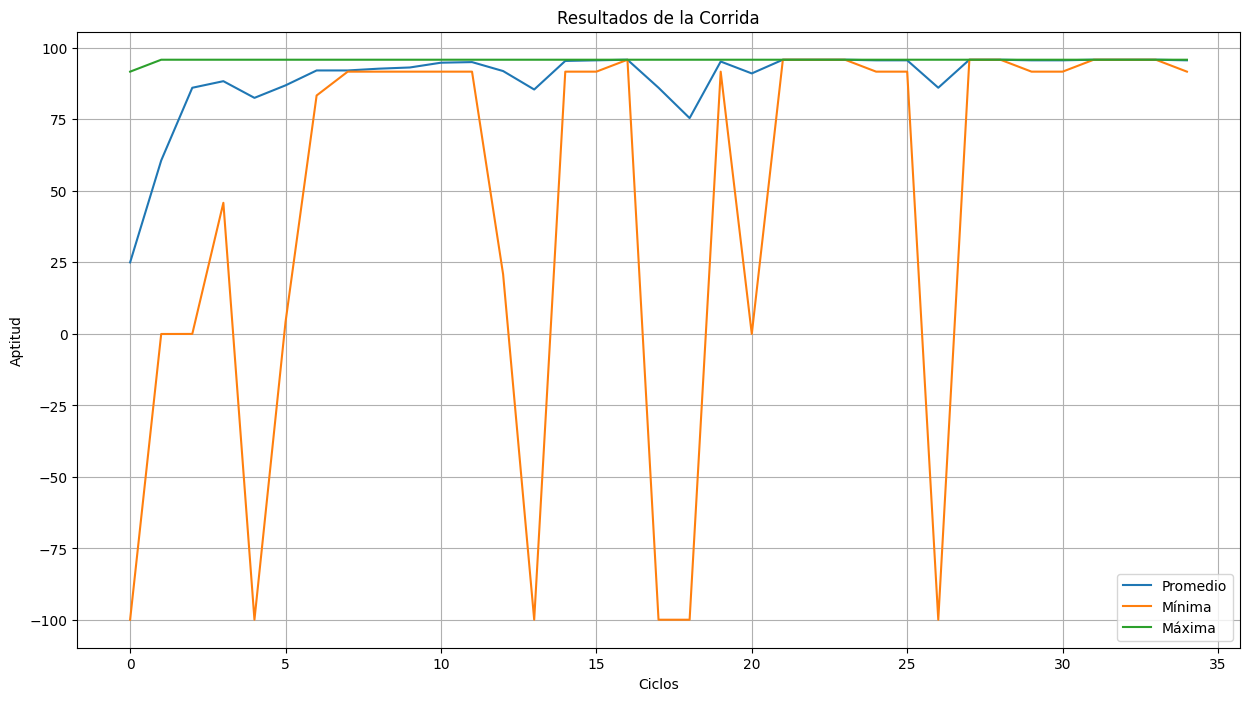

In [ ]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()


# Evaluación del mejor Modelo encontrado

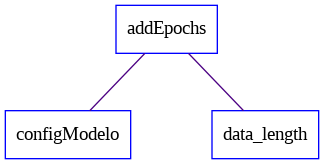


== Mejor Individuo de la Corrida: addEpochs(configModelo, data_length)  {  95.828  }  ==

> Configuración del modelo RNA id: 9128456270607557074
	 con 1 capas convolucionales:
		 kernel shape: 2
		 pooling tipo: Max y shape: 2
		 usando Flatten
	 sin capas ocultas lineales 
	 algoritmo de optimización: Adam, learning rate: 0.001
	 y entrenamiento con 250 épocas.

Modelo creado con  5  capas:


Model: "Model_9128456270607557074"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ slng_1_div_255 (Rescaling)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_c_1 (Conv2D)                    │ (None, 32, 32, 8)           │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_p_1 (MaxPooling2D)              │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flat (Flatten)                       │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,784 (241.35 KB)

 Trainable params: 20,594 (80.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,190 (160.90 KB)

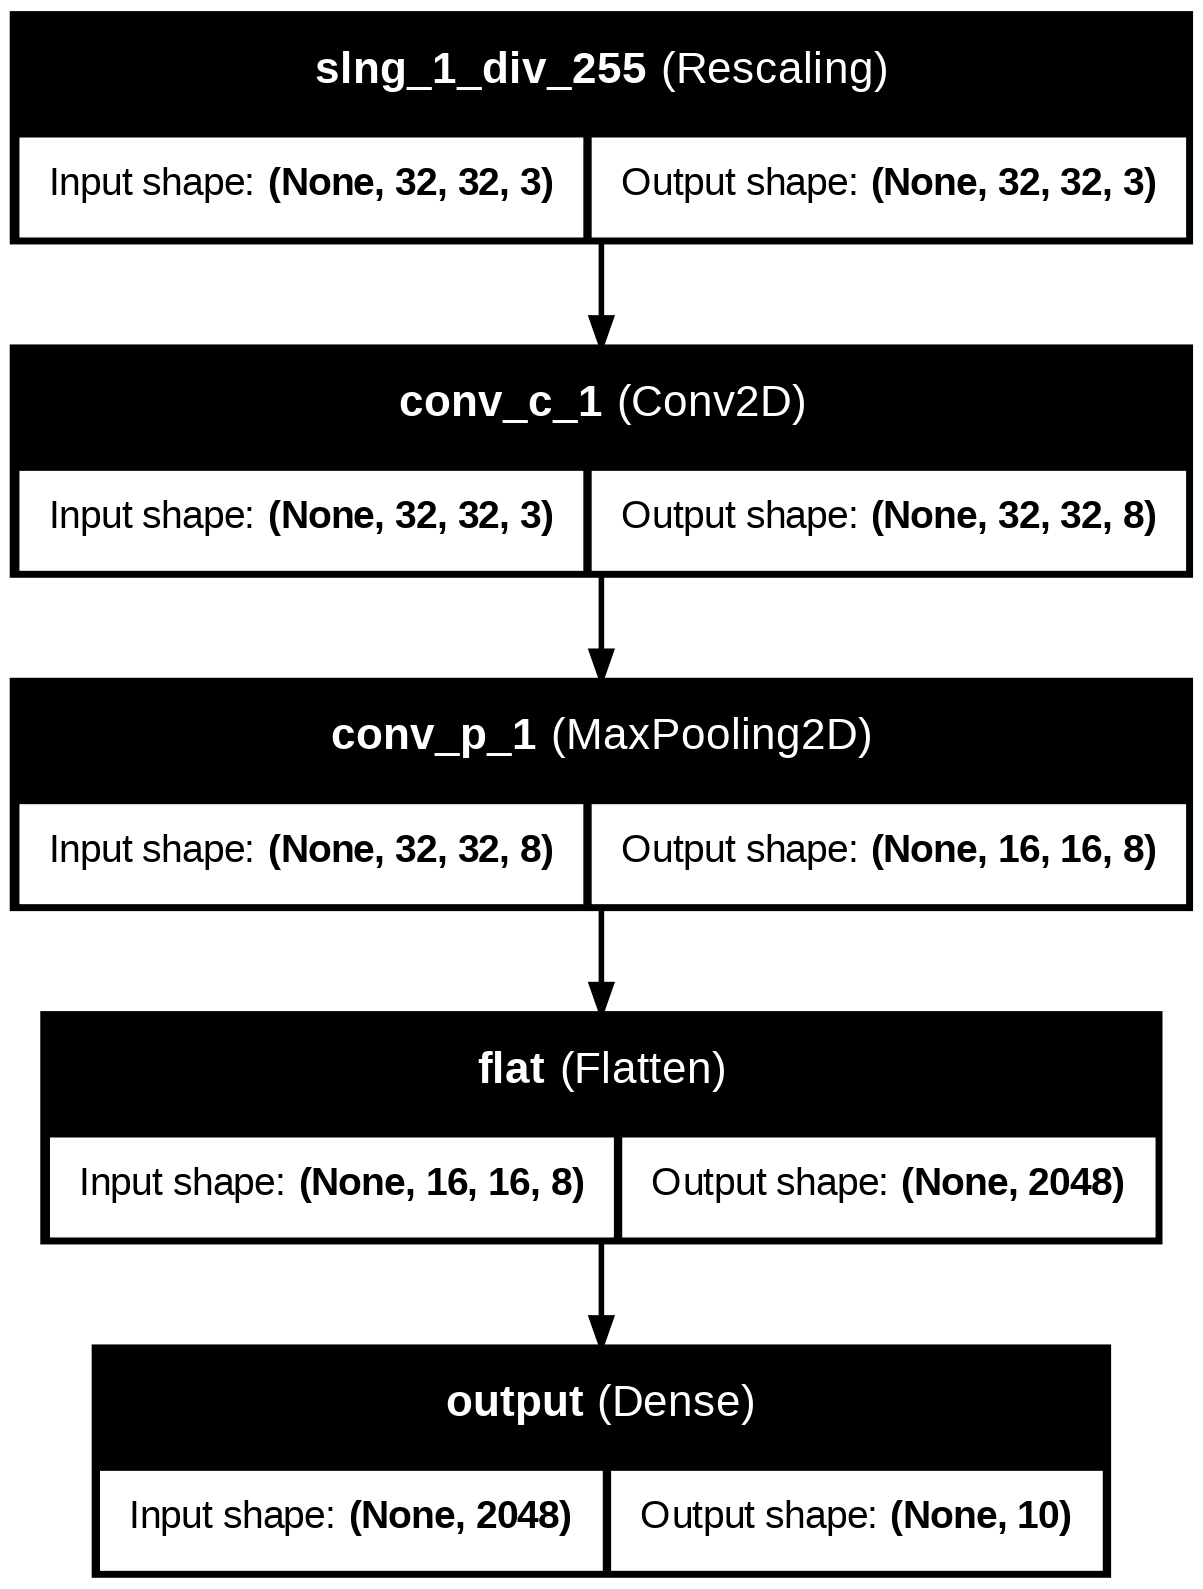

In [ ]:
#@title Mostrar Mejor Modelo

nodes, edges, labels = gp.graph( mejorIndCorrida )

#g = pgv.AGraph()
g = pgv.AGraph(overlap=False, splines='polyline') # indica tipo de uniones
g.graph_attr['label']='' # título
g.graph_attr['ranksep']='0.6' # separación entre niveles
g.graph_attr['nodesep']='1.3' # separación en el mismo nivel

g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='CantParts' or labels[i]=='Particulas':
      n.attr['shape']='oval'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'

# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")

g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))

# muestra mejor individuo
print("")
print("== Mejor Individuo de la Corrida:", mejorIndCorrida, " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")

# recupera RNA generada por el mejor indiviudo
isCached, mejorIndId, mejorIndFitness, mejorIndconfigModel, model = modeloEnv.models_cache_get(mejorIndCorrida)
if not isCached:
    print("\n--Warning: individuo no encontrado en cache, regenera!")
    mejorIndFitness, mejorIndconfigModel, model = aplicaExpresion(mejorIndCorrida)
# muestra configuración
showConfigDictModel(mejorIndconfigModel)
# muestra modelo
modeloEnv.show_model(model, showPlot=True)

In [ ]:
#@title Evaluar red entrenada con datos de entrenamiento


# explicación y fuente de GradCAM en:
#   https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759
def prepareGradCAM(model, last_conv_layer_name):
  # genera sub-modelo desde capa de entrada a última capa convultional
  last_conv_layer = model.get_layer(last_conv_layer_name)
  subModel = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  return subModel

def aplicarGradCAM(subModel, last_conv_layer_shape, imgOrig, intensity=0.5, res=250):
  # prepara la imagen a procesar
  img = copy.deepcopy(imgOrig)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  # genera el heatmap
  with tf.GradientTape() as tape:
    model_out, last_conv_layer = subModel(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape(last_conv_layer_shape) # (8, 8))
  # aplica el heatmap
  imgHM = copy.deepcopy(imgOrig)
  heatmap = cv2.resize(heatmap, (imgHM.shape[1], imgHM.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  imgHM = heatmap * intensity + imgHM
  # devuelve imagen con HeatMap
  return imgHM


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map, tipo_output_softMax, umbralClas=50.0, mostrarGradCAM=False, rtdo="TODOS", cantMostrar="TODAS", claseFiltrar=None):

    # determina clase a filtrar
    if (claseFiltrar is None) or (claseFiltrar == "-"):
          clFiltrarID = None
          mostrarImagenes = False
    elif (claseFiltrar == "TODOS"):
          clFiltrarID = None
          mostrarImagenes = True
    else:
          clFiltrarID = dictMapeo[claseFiltrar]
          mostrarImagenes = True
    if umbralClas <= 0.0:
      umbralClas = 0.1
    elif umbralClas >= 100.0:
      umbralClas = 99.0
    else:
      umbralClas = umbralClas/100.0

    # determina tipo de resultado a mostrar
    if rtdo == "Clasificación Incorrecta":
      tipoRes = -1
    elif rtdo == "Clasificación Correcta":
      tipoRes = 1
    else:
      tipoRes = 0

    if mostrarGradCAM:
      # genera submodelo
      subModel = prepareGradCAM(model, last_conv_layer_name)
      # si muestra GradCAM también muestra imagen original
      mostrarImagenes = True

    # determina cantidad a mostrar
    if (cantMostrar == "TODAS"):
      cantMostrar = len(x)
    elif (cantMostrar <= 0):
      cantMostrar = 0
      mostrarImagenes = False

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    # lista auxiliar para mostrar
    imgsParaMostrar = []

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                  idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )
        resClasOK = (clReal==clPred)

        if mostrarImagenes:

          # determina si filtra por clase
          if (clFiltrarID is None) or (clFiltrarID == y[i]):

            # filtra por tipo de resultado
            if (tipoRes==0) or \
              ((tipoRes > 0) and resClasOK) or\
              ((tipoRes < 0) and not(resClasOK)):
                # el titulo par aponer en la imagen
                strTitulo = 'Real: ' + str(clReal) + ' / Modelo: ' + str(clPred)
                if not resClasOK:
                  strTitulo = strTitulo + "!"
                #strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'

                # agrega para mostrar
                imgsParaMostrar.append( [strTitulo, x[i] ] )


    # cierra la imagen
    if mostrarImagenes and (cantMostrar>0) and (len(imgsParaMostrar)>0):
      print("\n>Detalle: ")

      if cantMostrar >= len(imgsParaMostrar):
        # muestra todas
        eligeImAlAzar = False
        cantMostrar = len(imgsParaMostrar)
      else:
        # muestra al azar
        eligeImAlAzar = True

      # prepara para mostrar imagenes
      if mostrarGradCAM:
        nCols = 2
        nRows = cantMostrar
        plt.figure(figsize=(5, 3*nRows))
      else:
        nCols = 3
        nRows = cantMostrar // nCols
        if (nRows*nCols) < cantMostrar:
          nRows = nRows + 1
        plt.figure(figsize=(10, 3*nRows))
      posImagen = 1

      for i in range(cantMostrar):
            # elige al azar o no para mostrar
            if eligeImAlAzar:
              posIm = random.randint(1, len(imgsParaMostrar))-1
            else:
              if i >= len(imgsParaMostrar):
                break
              else:
                posIm = i
            # determina datos a mostrar
            im = imgsParaMostrar[posIm][1]
            tit = imgsParaMostrar[posIm][0]

            # muestra la imagen
            ax = plt.subplot(nRows, nCols, posImagen)
            plot_image( im )
            plt.title( tit, fontsize=9 )
            posImagen = posImagen + 1

            # muestra resultado aplicar GRADCAM
            if mostrarGradCAM:
              imgGradCAM = aplicarGradCAM(subModel, last_conv_layer_shape, im)
              ax = plt.subplot(nRows, nCols, posImagen)
              plot_image( imgGradCAM )
              posImagen = posImagen + 1

            # saca elemento de la lista para no elegirlo al azar de nuevo
            if eligeImAlAzar:
              if len(imgsParaMostrar) > posIm:
                imgsParaMostrar.pop( posIm )

      #plt.tight_layout()
      fig = plt.gcf()
      plt.show()
      plt.close(fig)

    # genera lista de labels
    labels_clases_map =  list(set(classReal + classPreds))
    labels_clases_map.sort()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=labels_clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in labels_clases_map],
        columns=['m:{:}'.format(x) for x in labels_clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    #cmtx.sort_index(axis=0, inplace=True)
    #cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()

# genera toda la interface para evaluar modeo DAE
def crearUI_evaluarModelo(clDefecto, clases, ruidoPorDefecto, funcionCambiaSeleccion):

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}
  childrenList = []

  slider_umbral = widgets.FloatSlider(
      value=50,
      min=0,
      max=100.0,
      step=1.0,
      description='Umbral de Clasificación: ',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      style=style_3D,
      readout_format='.1f',
  )
  if not tipo_output_softMax:
    childrenList.append( slider_umbral )

  # prepara combo para filtrar por clase
  seleccion_CLASES = ["-", "TODOS"]
  seleccion_CLASES.extend( clases )
  seleccion_CLASES.sort()
  combo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefecto,
      description = 'Filtrar por clase:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_clase )

  # prepara combo para filtrar por resultado
  selecc_resutado = [ "TODOS", "Clasificación Incorrecta", "Clasificación Correcta" ]
  combo_resultado = widgets.Dropdown(
      options = selecc_resutado,
      value = selecc_resutado[0],
      description = 'Filtrar por resultado:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_resultado )

  # prepara combo para filtrar por cantidad
  selecc_cantidad = [ 3 ]
  selecc_cantidad.extend( range(6, 151, 9) )
  selecc_cantidad.append( "TODAS" )
  combo_cantidad = widgets.Dropdown(
      options = selecc_cantidad,
      value = 6,
      description = 'Mostrar N imágenes al azar:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_cantidad )

  mostrar_HeatMap_de_GradCAM = widgets.Checkbox(
        value=False,
        description='Mostrar HeatMap de GradCAM',
        disabled=False
    )
  ##childrenList.append( mostrar_HeatMap_de_GradCAM )


  prueba_ui = widgets.GridBox(children=childrenList,
          layout=Layout(width='100%')
        )
  out_prueba = widgets.interactive_output(funcionCambiaSeleccion, {'cant':combo_cantidad, 'rtdo': combo_resultado,'cl':combo_clase, 'h':mostrar_HeatMap_de_GradCAM, 'umbralClas':slider_umbral})

  return prueba_ui, out_prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl, h, umbralClas):

    # prueba con los datos de entrenamiento
    print("\n\n*** Resultados con datos de Entrenamiento: ")
    probarModelo(x_train, y_train, clases_map, tipo_output_softMax, umbralClas, h, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(Dropdown(description='Filtrar por clase:', options=('-', '0', '1', '2', '3', '4', '5', '6', …

Output()

In [ ]:
#@title Evaluar red entrenada con datos de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl, h, umbralClas):

  # prueba con los datos de prueba
  print("\n\n*** Resultados con datos de Prueba: ")
  probarModelo(x_test, y_test, clases_map, tipo_output_softMax, umbralClas, h, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(Dropdown(description='Filtrar por clase:', options=('-', '0', '1', '2', '3', '4', '5', '6', …

Output()

In [ ]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/ImagNeuroEvol'  #@param {type:"string"}

if guardar_modelo:

    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    model.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")

    if ("IMAGE_SHAPE" in locals()) and (IMAGE_SHAPE is not None):
      fn_imageShape = path_modelo+"/IMAGE_SHAPE.txt"
      with open(fn_imageShape, 'w') as f:
        for i in IMAGE_SHAPE:
          f.write(str(i)+"\n")
      print("\n-IMAGE_SHAPE para cargar las imágenes guardado en ", path_modelo,"\n")


    if ("clases_map" in locals()) and (clases_map is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(clases_map)):
          f.write(str(i)+":"+str(clases_map[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagNeuroEvol/model.keras 


-IMAGE_SHAPE para cargar las imágenes guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagNeuroEvol 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagNeuroEvol 

